In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs

In [2]:
class ANN:
    
    def __init__(self,layer_structure, learning_rate = 1e-3, epochs = 100):
        
        self.layer_structure = layer_structure
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.costs = []
        self.weights, self.biases = self.initialize_weights()
        
    def sigmoid(self,x):
        return 1/(1 + np.exp(-x))
    
    def soft_max(self,X):
        expX = np.exp(X)
        predictions = expX / expX.sum(axis=1, keepdims=True)
        
        return predictions
    
    def choose_classes(self):
        return np.argmax(self.layers[-1], axis = 1)
    
    def initialize_weights(self):
        
        weights = []
        for j, _ in enumerate(self.layer_structure):
            if j == 0:
                continue
            weights.append(np.random.randn(self.layer_structure[j-1],self.layer_structure[j]))
        biases = [np.random.randn(1,n) for n in self.layer_structure[1:]]
        return weights, biases
        
    def feed_forward(self, X):
        self.layers = []
        
        for j, weights in enumerate(self.weights):
            if j == 0:
                cur_layer = self.sigmoid(X.dot(weights) + self.biases[j])
                self.layers.append(cur_layer)
            elif j != len(self.weights)-1:
                cur_layer = self.sigmoid(cur_layer.dot(weights) + self.biases[j])
                self.layers.append(cur_layer)
            else:
                self.layers.append(self.soft_max(cur_layer.dot(weights) + self.biases[j]))
                    
    def cost(self, targets, predictions):
        return (targets * np.log(predictions)).sum()
    
    def backprop(self, targets, y, X):
        
        weights_derivatives = []
        biases_derivatives = []
                
        
        for layer in range(len(self.weights)-1,-1,-1):
            
            if layer == len(self.weights) - 1:
                w_deriv = self.layers[layer-1].T.dot(targets-self.layers[layer])
                b_deriv = (targets-self.layers[layer]).sum(axis = 0)
                weights_derivatives.append(w_deriv)
                biases_derivatives.append(b_deriv)
                
                w_deriv_growing_portion = ((targets-self.layers[layer]).dot(self.weights[layer].T) * 
                            self.layers[layer-1] * (1-self.layers[layer-1]))
                continue
            elif layer != 0:
                w_deriv = self.layers[layer-1].T.dot(w_deriv_growing_portion)
                b_deriv = w_deriv_growing_portion.sum(axis = 0)
                weights_derivatives.append(w_deriv)
                biases_derivatives.append(b_deriv)
                w_deriv_growing_portion = (w_deriv_growing_portion.dot(self.weights[layer].T) * 
                                             self.layers[layer-1] * (1-self.layers[layer-1]))
                                     
            else:
                w_deriv = X.T.dot(w_deriv_growing_portion)
                b_deriv = w_deriv_growing_portion.sum(axis = 0)
                
                weights_derivatives.append(w_deriv)
                biases_derivatives.append(b_deriv)
                
                weights_derivatives = weights_derivatives[::-1]
                biases_derivatives = biases_derivatives[::-1]
                
        self.weights_derivatives = weights_derivatives
        self.biases_derivative = biases_derivatives
        for layer, _ in enumerate(weights_derivatives):
            self.weights[layer] += weights_derivatives[layer]*self.learning_rate
            self.biases[layer] += biases_derivatives[layer]*self.learning_rate
                
    def train(self, X,y):
        count = 0
        targets = np.zeros((len(y), max(y)+1))
        for row, _ in enumerate(y):
            targets[row,y[row]] = 1
            
        
        
        while count < self.epochs:
            self.feed_forward(X)
            self.costs.append(self.cost(targets = targets, predictions = self.layers[-1]))
            self.backprop(targets=targets, y = y, X = X)
            count += 1
            
    def predict(self, X):
        
        self.feed_forward(X)
        return self.choose_classes()

In [3]:
testANN = ANN((2,10,5),epochs = 1000,learning_rate=1e-3)

In [4]:
X,y = make_blobs(n_samples= 1000, n_features=2, centers = 5, center_box = (-6,6))

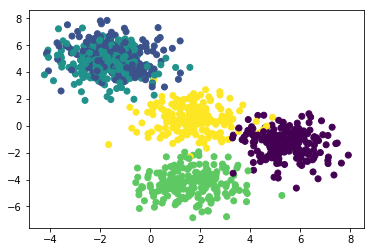

In [5]:
plt.scatter(X[:,0],X[:,1], c = y)

In [6]:
testANN.train(X,y)

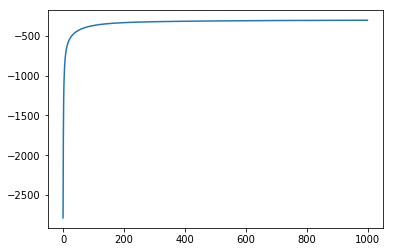

In [7]:
plt.plot(testANN.costs)

In [8]:
np.mean(testANN.predict(X) == y) #accuracy

0.825

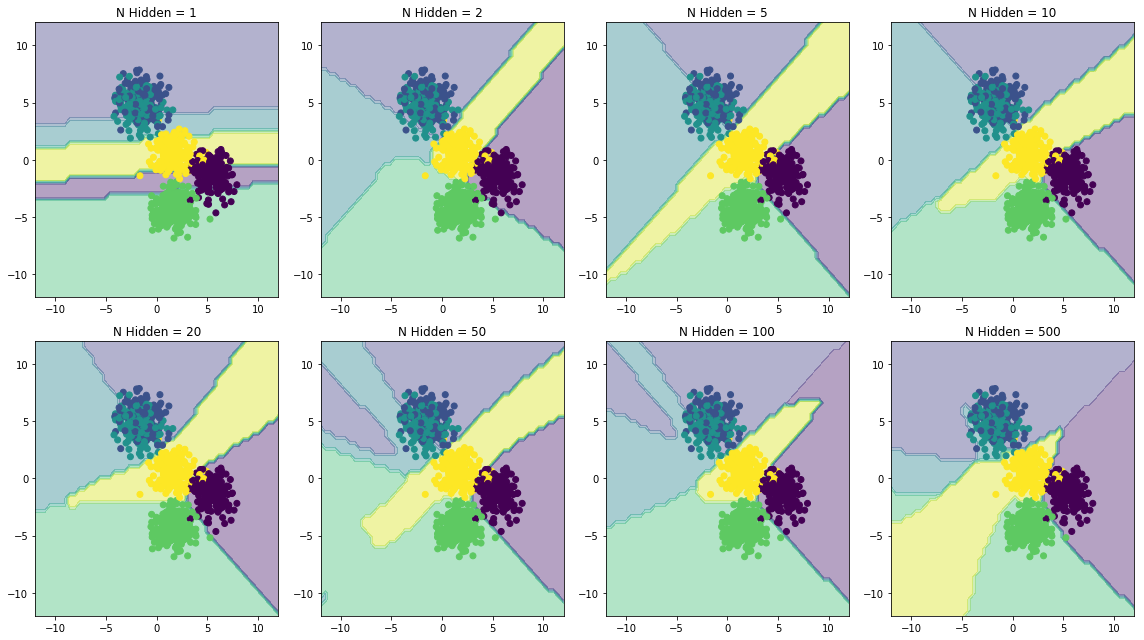

In [10]:
fig, ax = plt.subplots(2,4,figsize = (16,9))
count = 1
for nhidden in [1,2,5,10,20,50,100,500]:
    ann = ANN((2,nhidden,5), epochs = 1000, learning_rate=1e-3)
    ann.train(X,y)
    vector_space = np.meshgrid(np.linspace(-12,12), np.linspace(-12,12))
    predictions = ann.predict(np.c_[vector_space[0].ravel(), vector_space[1].ravel()])
    predictions = np.array(predictions).reshape(vector_space[0].shape)
    ax[(count-1)//4, (count-1)%4].contourf(vector_space[0],vector_space[1], predictions, alpha = 0.4)
    ax[(count-1)//4, (count-1)%4].scatter(X[:,0],X[:,1], c= y)

    ax[(count-1)//4, (count-1)%4].set_title('N Hidden = ' + str(nhidden))
    count += 1
plt.tight_layout()